In [1]:
# %load honest_net.py
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/honest_net.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


# C&P from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except TypeError:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    d = {}

    def wsg(k, v):
        d[k + "_weakest"] = v[weakest]
        d[k + "_strongest"] = v[strongest]
        d[k + "_gini"] = gini(v)

    rcompute = compute / np.sum(compute)
    wsg("compute", rcompute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / np.sum(activations)
    wsg("activations", ractivations)
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    wsg("reward", rreward)
    efficiency = rreward / ractivations
    wsg("efficiency", efficiency)
    d["activations_compute_gini_delta"] = d["activations_gini"] - d["compute_gini"]
    d["reward_activations_gini_delta"] = d["reward_gini"] - d["activations_gini"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

## Incentive Schemes for Georges  Protocol

In [2]:
d = df[df.protocol == "tailstormll"]

### Efficiency of the weakest miner

We pick the weakest miner by compute power and calculate its

efficiency = relative reward / relative activations

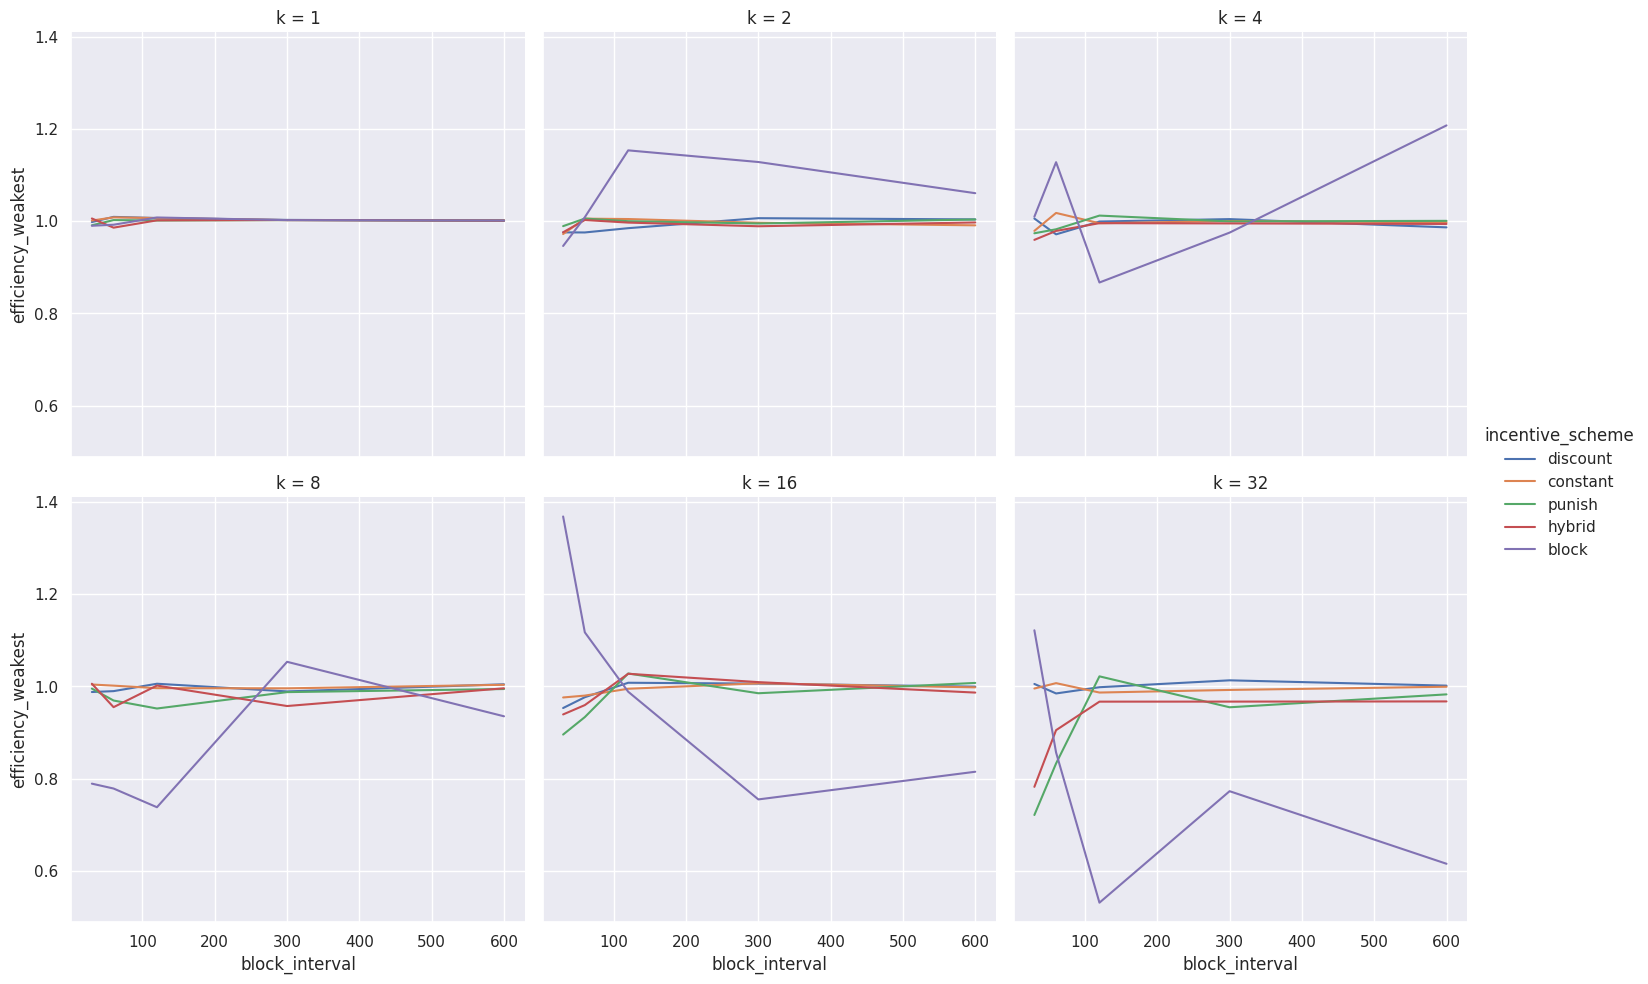

In [3]:
sns.relplot(
    data=d,
    x="block_interval",
    y="efficiency_weakest",
    col="k",
    col_wrap=3,
    hue="incentive_scheme",
    kind="line",
)

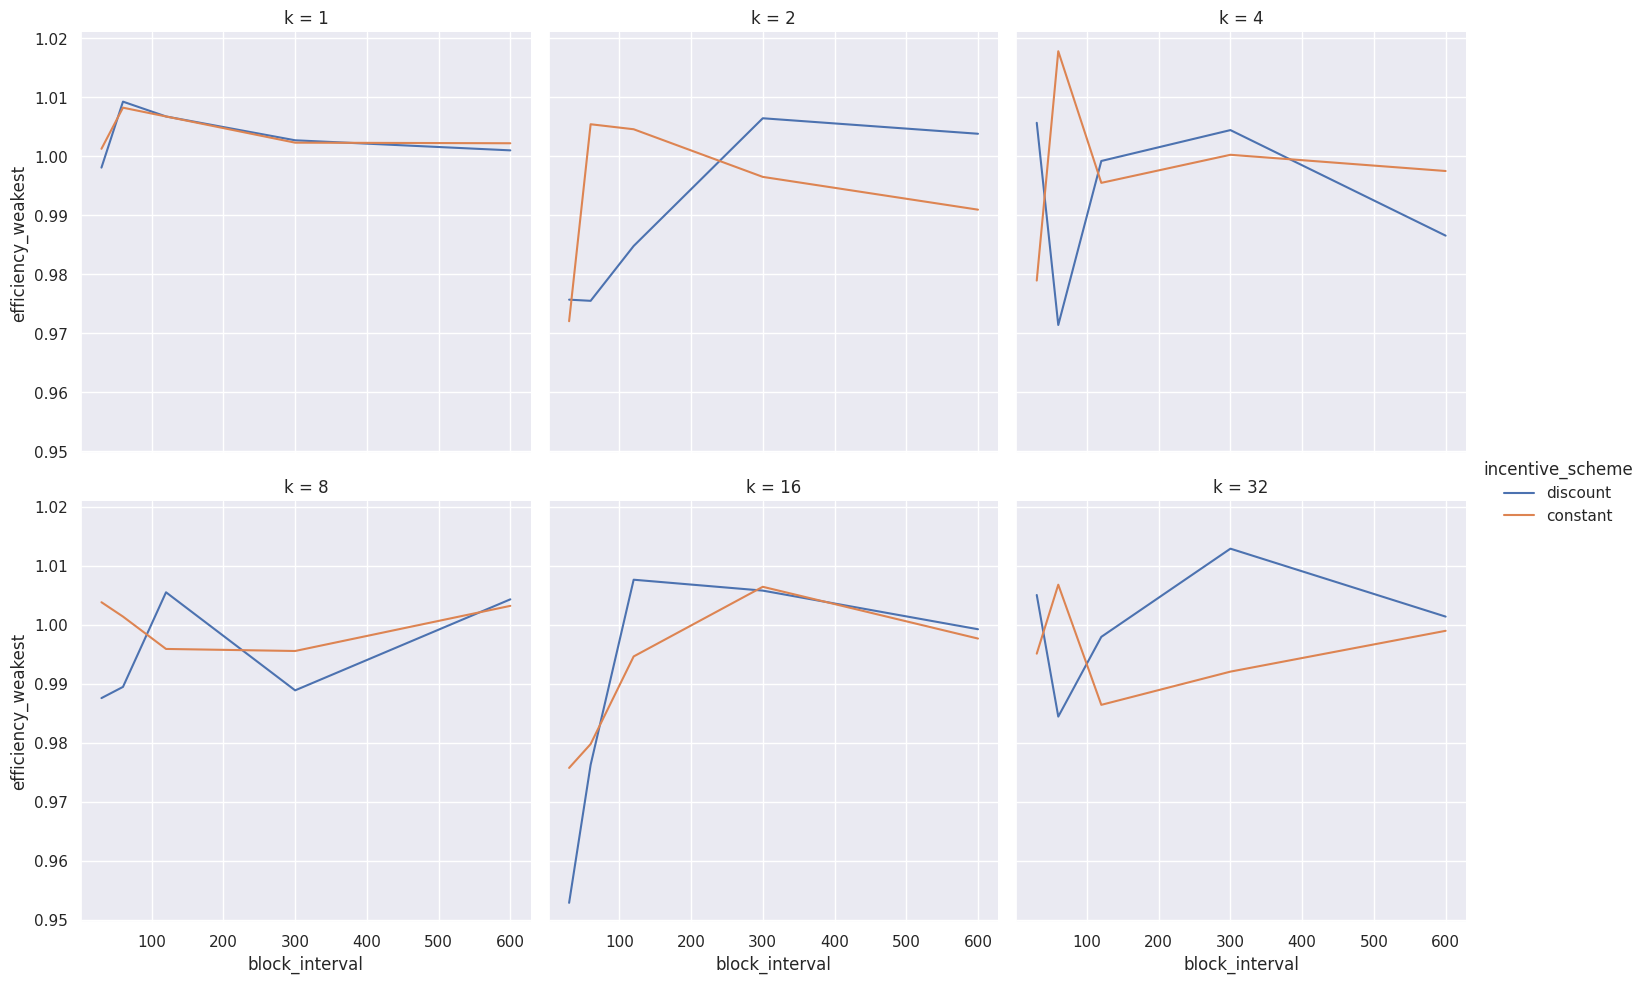

In [4]:
sns.relplot(
    data=d[
        (d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")
    ],
    x="block_interval",
    y="efficiency_weakest",
    col="k",
    col_wrap=3,
    hue="incentive_scheme",
    kind="line",
)

In [5]:
eff = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k"],
    columns=["Incentive Scheme"],
    values="efficiency_weakest",
)
eff.style.to_latex(buf="../../tex/george-reward-inequality/tab/efficiency-weakest.tex")
eff

Incentive Scheme      block  constant  discount    hybrid    punish
Block Interval k                                                   
30.0           1   0.990029  1.001264  0.998077  1.005801  0.991009
               2   0.946230  0.972041  0.975697  0.975894  0.989191
               4   1.009643  0.978934  1.005670  0.959449  0.973741
               8   0.789001  1.003826  0.987577  1.005531  0.995011
               16  1.367890  0.975743  0.952878  0.938985  0.895378
               32  1.121328  0.995109  1.005052  0.782118  0.721066
60.0           1   0.992225  1.008234  1.009258  0.985910  1.002298
               2   1.008516  1.005427  0.975498  1.002445  1.005613
               4   1.127768  1.017803  0.971401  0.978815  0.982367
               8   0.778446  1.001393  0.989475  0.954749  0.969135
               16  1.116913  0.979785  0.976266  0.959220  0.933215
               32  0.856634  1.006797  0.984442  0.904904  0.832722
120.0          1   1.007963  1.006745  1.006745  1.001765  1.001428
               2   1.153410  1.004578  0.984792  0.996881  0.999892
               4   0.867060  0.995493  0.999201  0.995625  1.012047
               8   0.737898  0.995908  1.005511  1.001571  0.951826
               16  0.988187  0.994638  1.007640  1.027106  1.027707
               32  0.531086  0.986433  0.997956  0.966707  1.021517
300.0          1   1.002205  1.002305  1.002707  1.002406  1.002305
               2   1.128153  0.996505  1.006441  0.988959  0.994916
               4   0.975158  1.000251  1.004435  0.995090  0.999423
               8   1.053017  0.995561  0.988889  0.957203  0.987351
               16  0.754831  1.006441  1.005795  1.009022  0.984906
               32  0.772648  0.992063  1.012903  0.966796  0.954496
600.0          1   1.001502  1.002205  1.001001  1.001101  1.001302
               2   1.060601  0.990950  1.003814  0.997167  1.003613
               4   1.207463  0.997502  0.986547  0.993966  1.000656
               8   0.934957  1.003210  1.004315  0.995655  0.994055
               16  0.814790  0.997668  0.999246  0.986336  1.007277
               32  0.615394  0.998981  1.001389  0.967203  0.982462

### Reward Gini Fairness

We compare the rewards of all miners using the Gini coefficient. A lower coefficient implies more fairness. All numbers should be compared to the Gini coefficient of the compute powers.

In [6]:
d.compute_gini.unique()

array([0.3])

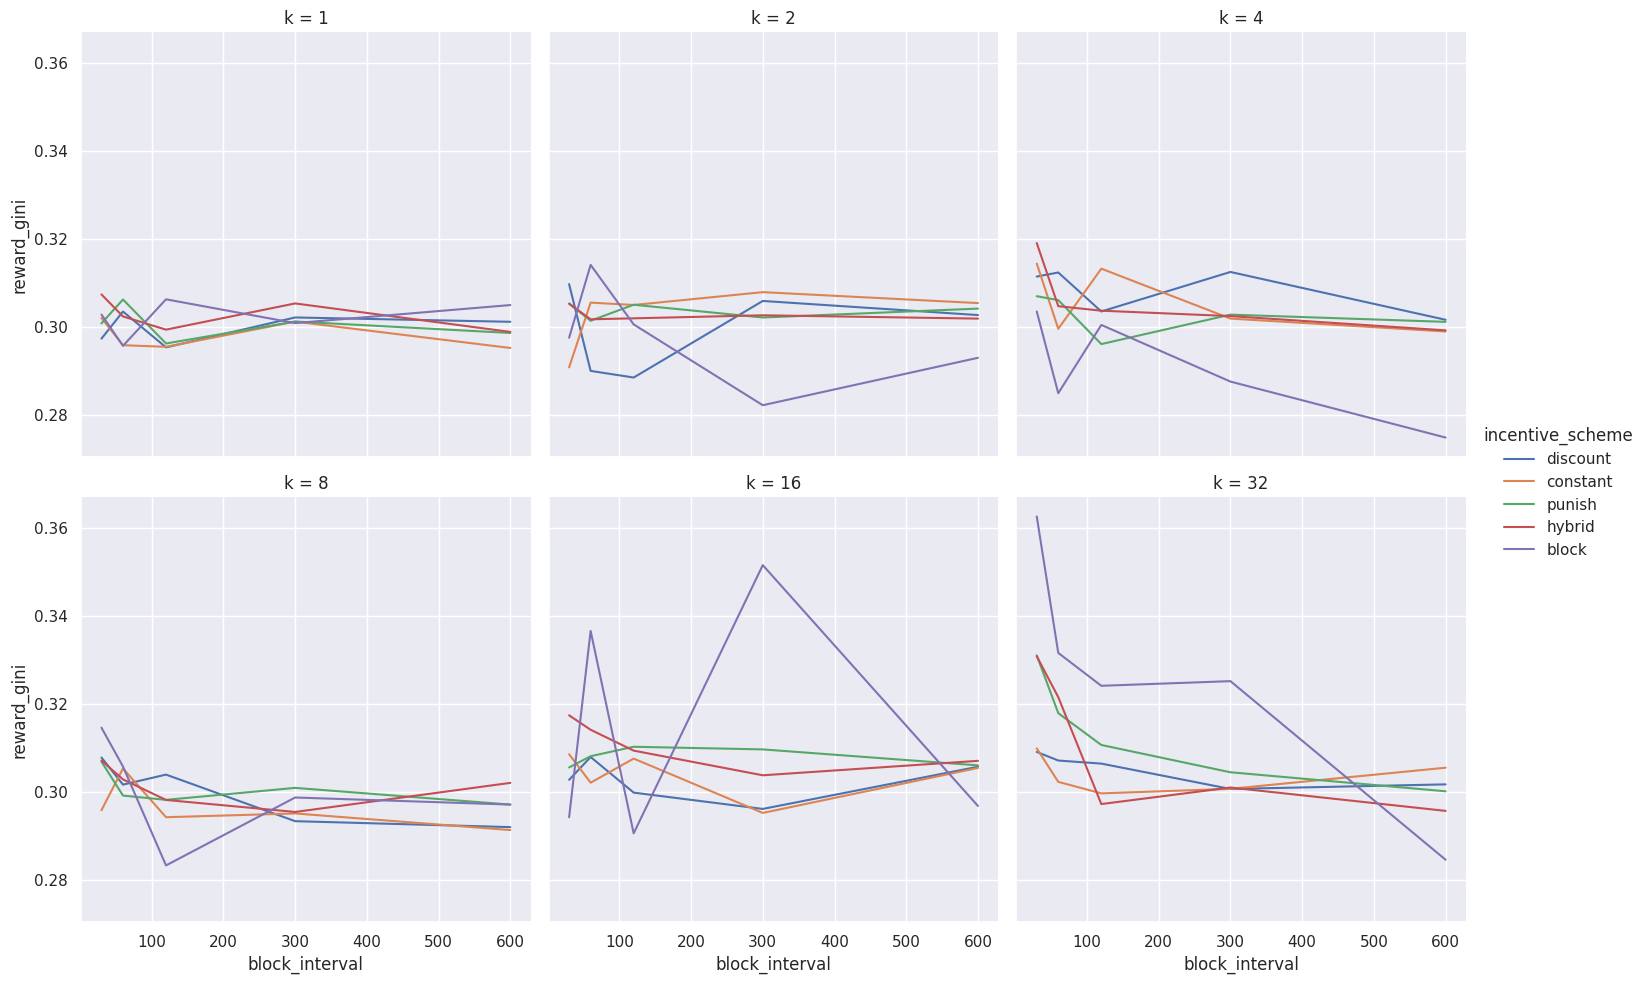

In [7]:
sns.relplot(
    data=d,
    x="block_interval",
    y="reward_gini",
    col="k",
    col_wrap=3,
    hue="incentive_scheme",
    kind="line",
)

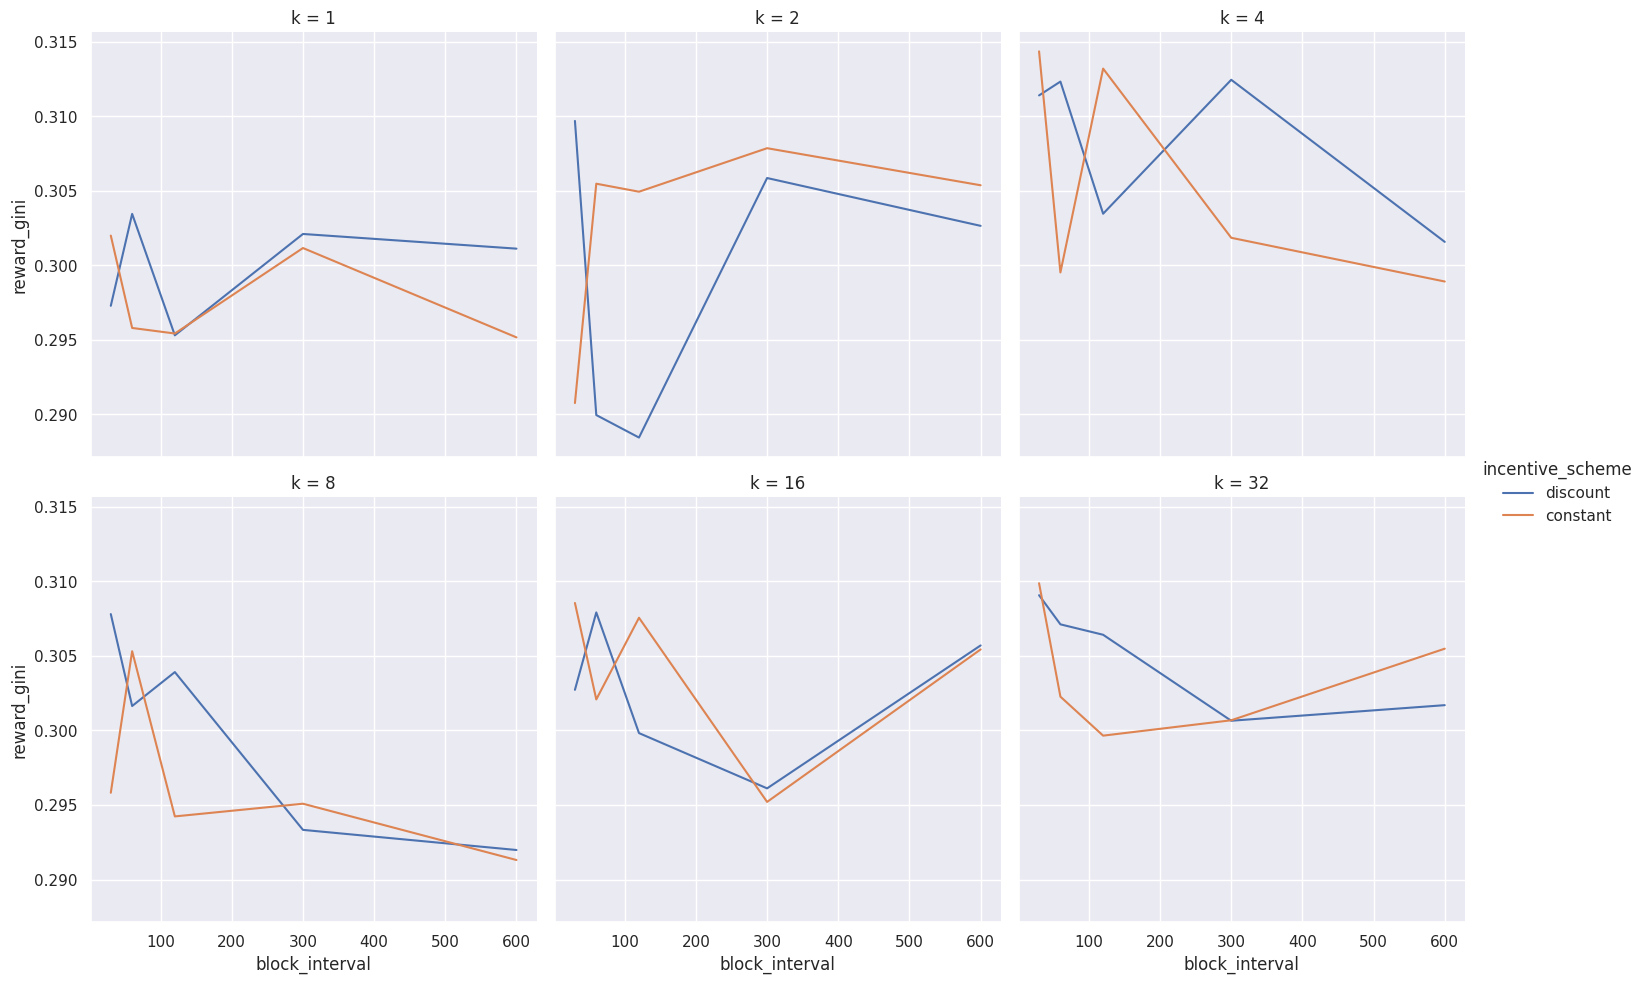

In [8]:
sns.relplot(
    data=d[
        (d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")
    ],
    x="block_interval",
    y="reward_gini",
    col="k",
    col_wrap=3,
    hue="incentive_scheme",
    kind="line",
)

In [9]:
gini = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k"],
    columns=["Incentive Scheme"],
    values="reward_gini",
)
gini.style.to_latex(buf="../../tex/george-reward-inequality/tab/reward-gini.tex")
gini

Incentive Scheme      block  constant  discount    hybrid    punish
Block Interval k                                                   
30.0           1   0.302762  0.301997  0.297288  0.307335  0.300762
               2   0.297488  0.290764  0.309687  0.305239  0.305262
               4   0.303470  0.314352  0.311400  0.319015  0.306932
               8   0.314589  0.295823  0.307807  0.307122  0.306863
               16  0.294228  0.308553  0.302728  0.317390  0.305546
               32  0.362585  0.309876  0.309073  0.330803  0.331022
60.0           1   0.295654  0.295802  0.303451  0.302333  0.306187
               2   0.314062  0.305478  0.289961  0.301690  0.301360
               4   0.284887  0.299527  0.312327  0.304669  0.306053
               8   0.305752  0.305317  0.301641  0.302832  0.299149
               16  0.336573  0.302083  0.307918  0.314113  0.308101
               32  0.331579  0.302269  0.307120  0.321527  0.317888
120.0          1   0.306229  0.295429  0.295309  0.299335  0.296193
               2   0.300528  0.304940  0.288451  0.301909  0.304998
               4   0.300405  0.313196  0.303464  0.303642  0.296054
               8   0.283279  0.294237  0.303917  0.298159  0.298179
               16  0.290569  0.307561  0.299826  0.309371  0.310247
               32  0.324104  0.299654  0.306420  0.297225  0.310654
300.0          1   0.300822  0.301163  0.302106  0.305293  0.301183
               2   0.282159  0.307858  0.305857  0.302598  0.302095
               4   0.287530  0.301850  0.312447  0.302413  0.302747
               8   0.298713  0.295089  0.293334  0.295429  0.300902
               16  0.351530  0.295209  0.296118  0.303763  0.309648
               32  0.325161  0.300685  0.300654  0.300982  0.304450
600.0          1   0.304927  0.295169  0.301121  0.298819  0.298578
               2   0.292936  0.305373  0.302650  0.301846  0.304115
               4   0.274809  0.298917  0.301576  0.299174  0.301107
               8   0.297108  0.291312  0.291984  0.302039  0.297105
               16  0.296790  0.305437  0.305705  0.307050  0.306018
               32  0.284566  0.305486  0.301699  0.295671  0.300126